Apply K-Correction to an LRG spectrum

In [1]:
import pandas as pd
import numpy as np
import pandas

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

In [2]:
data = Table.read('lrg.fits', format='fits')
df = data.to_pandas()
print('Number of rows in spectrum file: ' + str(len(df.index)))
df.head()

Number of rows in spectrum file: 2560


,LAMBDA,FLAMBDA
0,1000.65,0.00001
1,1001.51,0.00001
2,1002.36,0.00001
3,1003.23,0.00001
4,1004.09,0.00001


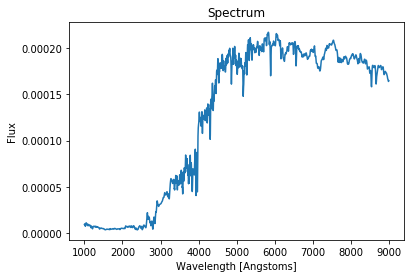

In [3]:
plt.figure()
plt.plot(df['LAMBDA'], df['FLAMBDA'])
plt.title('Spectrum')
plt.xlabel("Wavelength [Angstoms]")
plt.ylabel("Flux")
plt.show()

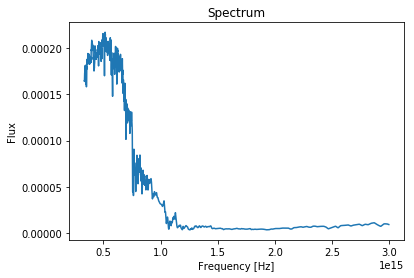

In [4]:
df['FREQUENCY'] = 2.99792458e18 / df['LAMBDA'].values
df.head()
plt.figure()
plt.plot(df['FREQUENCY'], df['FLAMBDA'])
plt.title('Spectrum')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Flux")
plt.show()

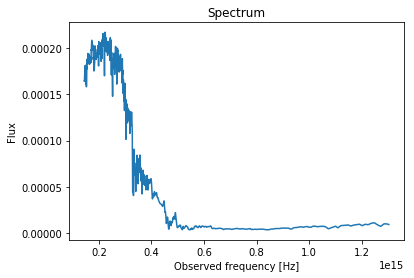

In [5]:
z = 1.3
df['OBSERVED_FREQUENCY'] = df['FREQUENCY'].values/(1+z)
df.head()
plt.figure()
plt.plot(df['OBSERVED_FREQUENCY'], df['FLAMBDA'])
plt.title('Spectrum')
plt.xlabel("Observed frequency [Hz]")
plt.ylabel("Flux")
plt.show()

In [6]:
# Comand shell - transmission curves of the filters files
print('Number of rows in the g filter transmission file:')
! cat filters/DECam_g.dat | wc -l
passband = pd.read_csv('filters/DECam_g.dat',
                           names=['WAVELENGTH', 'TRANSMISSION'],
                           delim_whitespace=True, comment='#')
passband.head()

Number of rows in the g filter transmission file:
201


,WAVELENGTH,TRANSMISSION
0,3740.0,0.0
1,3750.0,0.0
2,3760.0,0.0
3,3770.0,0.0
4,3780.0,0.0


In [7]:
def read_passband(band):
    """                                                                                                                                                                                                                                                                                                                                                                        
    Read and interpolate filter transmission curves                                                                                                                                                                                                                                                                                                                             

    :param band: the single-letter band identifier                                                                                                                                                                                                                                                                                                                             
    :return: transmisison_frequency: interpolated filter transmission as a function of frequency                                                                                                                                                                                                                                                                               
    :return: transmisison_wavelength: interpolated filter transmission as a function of wavelength                                                                                                                                                                                                                                                                             
    """
    #Target filter file associated with band                                                                                                                                                                                                                                                                                                                                   
    filter_file = 'filters/DECam_{}.dat'.format(band)  #[x for x in self.filter_files if x.find('_' + band) != -1][0]

    # Read and format filter transmission info                                                                                                                                                                                                                                                                                                                                 
    passband = pd.read_csv(filter_file,
                           names=['WAVELENGTH', 'TRANSMISSION'],
                           delim_whitespace=True, comment='#')

    # Add boundary terms to cover the whole range                                                                                                                                                                                                                                                                                                                              
    passband.loc[passband.shape[0]] = (1.e-1, 0.0)
    passband.loc[passband.shape[0]] = (4.e+4, 0.0)

    # Convert to frequency using speed of light in angstroms                                                                                                                                                                                                                                                                                                                   
    passband['FREQUENCY'] = 2.99792458e18 / passband['WAVELENGTH'].values
    passband['OBSERVED_FREQUENCY'] = passband['FREQUENCY'].values/(1+z)

    # Interpolate and return                                                                                                                                                                                                                                                                                                                                                   
    transmission_frequency = interp1d(passband['FREQUENCY'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    transmission_wavelength = interp1d(passband['WAVELENGTH'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    transmission_frequency_obs = interp1d(passband['OBSERVED_FREQUENCY'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    
    return transmission_frequency, transmission_wavelength, transmission_frequency_obs

In [8]:
g_transmission_frequency, g_transmission_wavelength, g_transmission_frequency_obs = read_passband('g')
i_transmission_frequency, i_transmission_wavelength, i_transmission_frequency_obs = read_passband('i')
r_transmission_frequency, r_transmission_wavelength, r_transmission_frequency_obs = read_passband('r')
y_transmission_frequency, y_transmission_wavelength, y_transmission_frequency_obs = read_passband('Y')
z_transmission_frequency, z_transmission_wavelength, z_transmission_frequency_obs = read_passband('z')

In [9]:
g_transmission_w = g_transmission_wavelength(df['LAMBDA'].values)
i_transmission_w = i_transmission_wavelength(df['LAMBDA'].values)
r_transmission_w = r_transmission_wavelength(df['LAMBDA'].values)
y_transmission_w = y_transmission_wavelength(df['LAMBDA'].values)
z_transmission_w = z_transmission_wavelength(df['LAMBDA'].values)

g_transmission_f = g_transmission_frequency(df['FREQUENCY'].values)
i_transmission_f = i_transmission_frequency(df['FREQUENCY'].values)
r_transmission_f = r_transmission_frequency(df['FREQUENCY'].values)
y_transmission_f = y_transmission_frequency(df['FREQUENCY'].values)
z_transmission_f = z_transmission_frequency(df['FREQUENCY'].values)

g_transmission_f_o = g_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)
i_transmission_f_o = i_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)
r_transmission_f_o = r_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)
y_transmission_f_o = y_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)
z_transmission_f_o = z_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)

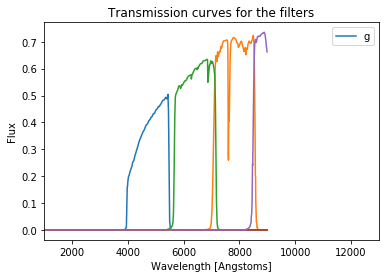

In [10]:
plt.figure()
plt.title('Transmission curves for the filters')
plt.xlim(1000,13000)
plt.plot(df['LAMBDA'].values, g_transmission_w)
plt.plot(df['LAMBDA'].values, i_transmission_w)
plt.plot(df['LAMBDA'].values, r_transmission_w)
plt.plot(df['LAMBDA'].values, y_transmission_w)
plt.plot(df['LAMBDA'].values, z_transmission_w)
plt.legend('g')
plt.xlabel("Wavelength [Angstoms]")
plt.ylabel("Flux")
plt.show()

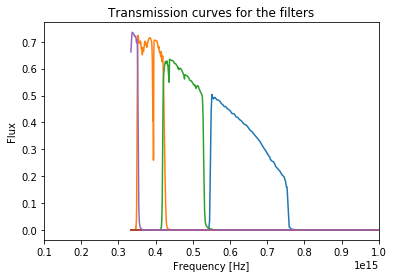

In [11]:
plt.figure()
plt.xlim(1e14,1e15)
plt.title('Transmission curves for the filters')
plt.plot(df['FREQUENCY'].values, g_transmission_f)
plt.plot(df['FREQUENCY'].values, i_transmission_f)
plt.plot(df['FREQUENCY'].values, r_transmission_f)
plt.plot(df['FREQUENCY'].values, y_transmission_f)
plt.plot(df['FREQUENCY'].values, z_transmission_f)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Flux")
plt.show()

In [22]:
from scipy.integrate import quad
#g_band_integrand = df['FLAMBDA'].values * g_transmission_w
#g_band_integrand_interpolated = interp1d(df['LAMBDA'].values, g_band_integrand)
#result = quad(g_band_integrand_interpolated, df['LAMBDA'].values[0], df['LAMBDA'].values[-1])
#print(result[0])

In [29]:
g_first_term_integrant = (df['FLAMBDA'].values * g_transmission_f_o)/ df['OBSERVED_FREQUENCY'].values
g_first_term_integrant_interpolated = interp1d(df['OBSERVED_FREQUENCY'].values, g_first_term_integrant)
g_first_term = quad(g_first_term_integrant_interpolated, df['OBSERVED_FREQUENCY'].values[0], df['OBSERVED_FREQUENCY'].values[-1])[0]
print(g_first_term)

g_fourth_term_integrant = (df['FLAMBDA'].values * g_transmission_f)/ df['FREQUENCY'].values
g_fourth_term_integrant_interpolated = interp1d(df['FREQUENCY'].values, g_fourth_term_integrant)
g_fourth_term = quad(g_fourth_term_integrant_interpolated, df['FREQUENCY'].values[0], df['FREQUENCY'].values[-1])[0]
print(g_fourth_term)

k_correction = -2.5*np.log10( (1+z) * (g_first_term/g_fourth_term) )
print(k_correction)

-2.0481309332969327e-05
-2.0481309332969324e-05
-0.9043195900439824


/home/jimenagonzalez/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jimenagonzalez/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singu

0.09921667219176956
